In [17]:
#Imports

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


#A bandit model, consisting of reward coefficient mean, covariance, and \theta estimate.
class model:
    def __init__(self,mean,cov):
        self.mean = mean
        self.cov = cov
        self.theta = 0
        

        
#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self,params,prior_model,nInteract):
        #initialize everything
        self.pi_min = params[0]
        self.pi_max = params[1]
        self.v = 1e-1 #tuning parameter - multiplier on bandit prior covariances
        self.nInteract = nInteract
        
        #Initialize model to prior data model
        self.model = model(params[2]*prior_model.mean,np.eye(len(prior_model.mean)) + params[2]*prior_model.cov)
        #self.model.mean = params.prior_weight*prior_model.mean
        
        #self.model.cov = np.eye(model.n) + prior_weight*prior_model.cov
        
    ######
    
    def get_reward_func(self): #Do the regression to estimate reward function
        reg_coefs = np.dot(np.linalg.inv(self.model.cov) , self.model.mean) #Regression estimate
        self.model.theta = reg_coefs[:self.nInteract]
        return self.model
    
    #####
    
    def update_model(self, featVec,reward, missing_data_flags, action,prob):
        #Thompson sampling eqns
        fTilde = np.concatenate((action * featVec[:self.nInteract].reshape((-1, 1)), featVec.reshape((-1, 1))), axis=0)
        
        self.model.mean = self.model.mean + fTilde*reward #featVec.reshape((-1, 1))*reward * (action - 0*prob)
        self.model.cov = self.model.cov + (np.outer(fTilde , fTilde)) #
        
        

        
        
########
#Utility function to get action probability on user side. Does not affect class or object
def action_probability(featVec,bandit):
    current_model = bandit.get_reward_func()
    
    #Probability of Gaussian scalar exceeding threshold
    featInteract = featVec[:bandit.nInteract]
    mean = np.dot( featInteract, current_model.theta)
    cv = np.linalg.inv(current_model.cov)
    variance = bandit.v**2 * np.dot(featInteract.transpose() , np.dot(cv[:bandit.nInteract,:bandit.nInteract], featInteract.reshape((-1, 1))))
    pi_0 = 1-norm.cdf(0, mean, np.sqrt(variance))
    #print current_model.theta.shape
    if pi_0 < bandit.pi_min:
        alpha = bandit.pi_min
    elif pi_0 > bandit.pi_max:
        alpha = bandit.pi_max
    else: 
        alpha = pi_0
        
    return alpha #probability of taking action 1

#######


In [24]:
#Create a reward function, used for this simulation only. Isaac you will not need this.
def reward(featVec,action,coef0,coef1,sig):
    
    nInteract = len(coef1)
    #linear funcs here
    fTilde = np.concatenate((action * featVec[:nInteract].reshape((-1, 1)), featVec.reshape((-1, 1))), axis=0)
    
    coefVec = np.concatenate((coef1.reshape((-1, 1)),coef0.reshape((-1, 1))),axis=0)
    rwd = np.dot(fTilde.transpose(),coefVec)
    
    return rwd





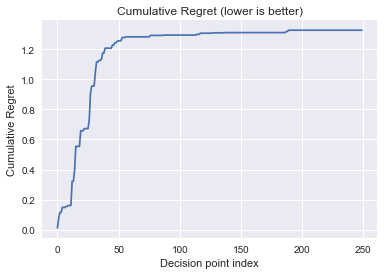

In [25]:
#A simulation. Isaac: Edit this as needed and described below.

nInteract = 3 #dimension (numer of interaction features)
nBaseline = 7 #dimension (number of baseline features, >= nInteract by definition)
T = 50 #days of study
t = 5 #decision points per day

#ISAAC REPLACE THESE WITH "TRUE" ETA AND THETA COEFFICIENTS.
coef0 = 1*np.random.normal(0,1,nBaseline) #Reward coefficients for baseline (ETA)
coef1 = .2*np.random.normal(0,1,nInteract) #Reward coefficients for interaction (THETA)


sig = 1e-1 #Reward noise standard deviation (zero mean Gaussian noise)

#Create a bandit object
params = [.2, .8, 0]#[minprob, maxprob, priorweight]
prior_mdl= model(np.zeros((nInteract+nBaseline,1)),np.eye(nInteract+nBaseline)) #Initialize bandit to very simple prior distribution
bandit = ContextBandit(params,prior_mdl,nInteract) #Create and initialize bandit

#creating variables for saving history of what we do
regret = np.zeros(T*t)
probs= np.zeros(T*t)
action = np.zeros(T*t)
#Cycle thru days
for day in range(T):
    
    rwd = np.zeros(t)
    
    featVec = np.zeros((nBaseline,t))
    #Cycle thru decision points in each day
    for dpt in range(t):
        #Generate random state vector 
        #ISAAC: Insert simulated user state s_t here.
        featVec[:,dpt] = np.random.normal(0,1,nBaseline) + .25*coef0
        
        #Get action probability from bandit
        #ISAAC: probs[] is the probability of taking action 1 at current decision point, i.e. \pi_t(1|s_t) in the doc (Quality metrics 1&2).
        featInteract = featVec[:nInteract,dpt] #only use the interaction features
        if 0: #Do nothing
            probs[day*t + dpt] = 0
        else: #Use bandit
            probs[day*t + dpt] = action_probability(featInteract,bandit)
            
        
        #Choose action based on probability, i.e. do the randomization
        if np.random.rand() < probs[day*t + dpt]:
            action[day*t + dpt] = 1
        else:
            action[day*t + dpt] = 0
        
        #Receive reward from the universe. As written has Gaussian noise - Isaac remove (can use 0 instead of sig).
        #ISAAC: Insert simulated user residuals here, as the "noise".
        rwd[dpt] = reward(featVec[:,dpt],action[day*t + dpt],coef0,coef1,sig)
        
        
        #What was expected regret given probability chosen by bandit?
        #ISAAC: Will need to use simulated user rewards for both action 0 and action 1 
        #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
        rwd0 = reward(featVec[:,dpt],0,coef0,coef1,0)
        rwd1 = reward(featVec[:,dpt],1,coef0,coef1,0)
        #Expected reward under bandit policy
        rwdExp = probs[day*t + dpt]*rwd1 + (1-probs[day*t + dpt])*rwd0
        
        #Regret is difference between optimal reward and the reward we got
        #"Optimal" reward is restricted based on the min/max allowed probabilities
        #ISAAC: THIS IS THE REGRET AT THE CURRENT DECISION POINT. Cumulative regret is formed by summing this up from time 0 to the current time.
        regret[day*t + dpt] = max(params[0]*rwd0 + params[1]*rwd1,params[0]*rwd1 + params[1]*rwd0) - rwdExp
        
        
    #Perform bandit updates at end of day
    for dpt in range(t):
               
        bandit.update_model(featVec[:,dpt],rwd[dpt],np.zeros(nInteract+nBaseline),action[day*t + dpt],probs[day*t + dpt])
        
        
#Plot cumulative regret
#ISAAC: This plots the Cumulative Regret (Quality metric 5).
plt.plot(np.cumsum(regret))
plt.title('Cumulative Regret (lower is better)')
plt.xlabel('Decision point index')
plt.ylabel('Cumulative Regret')


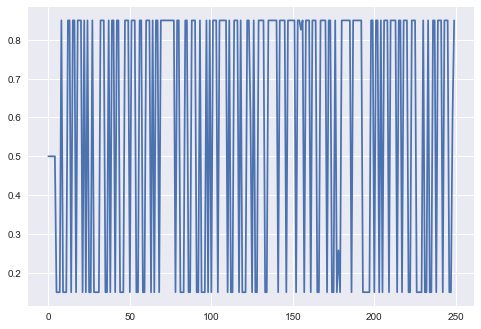

In [4]:
plt.plot(probs) #probabilities of taking action 1

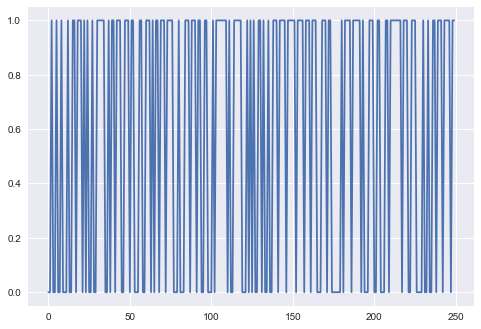

In [5]:
plt.plot(action) #actions actually taken

In [2]:
330.0/17800

0.01853932584269663

In [3]:
33+45+60+15+150+17

320